In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import scipy.optimize
from answers import show_answer
from src.lor96 import dxdt, step_solver, integration_between_obs 

Vamos a especificar un modelo de Markov escondido:

\begin{align*}
x_0 &\sim p(x_0) \\
x_t &= M(x_{t-1}) + q_t \\
y_t &= H(x_t) + r_t
\end{align*}

donde $q_t$ y $r_t$ son procesos de ruido. Consideraremos que estos procesos no varían en el tiempo y que son Gaussianos. Si escribimos $q_t \sim N(0, Q)$ y $r_t \sim N(0, R)$ podemos expresar las ecuaciones del modelo como:

\begin{align*}
x_0 &\sim p(x_0) \\
p(x_t | x_{t-1}) &\sim N(M(x_{t-1}), Q) \\
p(y_t | x_t) &\sim N(H(x_t), R)
\end{align*}

Para probar técnicas de asimilación de datos usaremos el modelo dinámico caótico Lorenz96, definido por el siguiente conjunto de ecuaciones diferenciales para $i = 1, ..., N$:

$$
\frac{dx_i}{dt} = (x_{i+1} - x_{i-2}) x_{i-1} - x_i + F
$$


### Discretización del tiempo

In [1]:
# Tomamos una grilla de tiempo desde t=0 hasta t=Tmax 
# discretizada en intervalos de longitud dt
# dkobs indica cuantos puntos de la grilla separan observaciones consecutivas
ncy = 500
dkobs = 10
dt = 0.01

Tmax = ncy * dkobs *dt
obs_idxs = np.arange(dkobs, ncy*dkobs+1, dkobs)
time_grid = np.arange(0, Tmax+dt, dt)[obs_idxs]

print('Tiempo inicial = 0\n'+
     'Tiempo final = {}\n'.format(Tmax) +
      'Numero de observaciones a ser procesadas = {}\n'.format(ncy) +
     'Observaciones cada {} pasos'.format(dkobs))

NameError: name 'np' is not defined

### Especificación del modelo

El modelo dinámico $M$ será la evolución de las ecuaciones diferenciales a través de los pasos de tiempo entre observaciones. $H$ mediante la cual se obtienen las observaciones. Los respectivos procesos de ruido $q_t$ y $r_t$, dadas las supocisiones de independencia en el tiempo y Gaussianidad, estarán completamente determinados por las matrices de covarianzas $Q$ y $R$

In [18]:
# Definimos la dimensión del sistema y el término de forcing
N = 40
F = 8
solver = step_solver(dxdt(N, F))
M = integration_between_obs(solver, dkobs, dt)

sigma_q = 1.5
Q = np.eye(N) * sigma_q
model_noise = scipy.stats.multivariate_normal(np.zeros(N), Q)

Nobs = 40
H = np.eye(Nobs) # Se observa el estado completo
sigma_r = 1.0
R = np.eye(Nobs) * sigma_r
observation_noise = scipy.stats.multivariate_normal(np.zeros(Nobs), R)

print('Q:\n', Q)

Q:
 [[1.5 0.  0.  ... 0.  0.  0. ]
 [0.  1.5 0.  ... 0.  0.  0. ]
 [0.  0.  1.5 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 1.5 0.  0. ]
 [0.  0.  0.  ... 0.  1.5 0. ]
 [0.  0.  0.  ... 0.  0.  1.5]]


### Spin-up
Para comenzar desde un valor inicial realista evolucionaremos el modelo a través de muchos pasos de tiempo

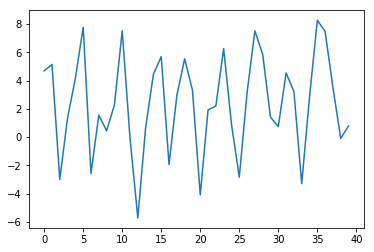

In [19]:
x0 = scipy.stats.multivariate_normal(np.zeros(N), np.eye(N)).rvs()
N_spin_up = 1000
for i in np.arange(N_spin_up):
    x0 = M(i, x0)
    
plt.plot(np.arange(N), x0)

### Generación de la _"verdad"_ y las observaciones sintéticas

Evolucionaremos el modelo creando el estado verdadero (el cual queremos estimar). En base a este generaremos observaciones sintéticas (las cuales usaremos para la estimación)

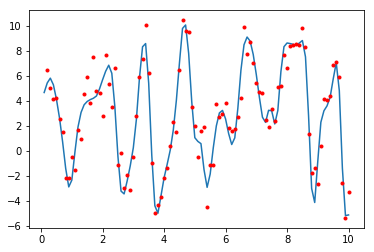

In [20]:
# Generamos la verdad y las observaciones

# xt es guarda al estado real e y a las observaciones.
# y contendrá un nan en el primer tiempo, pues es una convención que en t=0 no hay observaciones
xt = np.zeros((N, ncy))
y = np.zeros((Nobs, ncy))
y[:, 0] = np.nan

# Definimos el estado inicial
xt[:, 0] = x0


for t in np.arange(1, ncy):
    xt[:, t] = M(t, xt[:, t-1])
    y[:, t] = H.dot(xt[:, t] + model_noise.rvs())

# Ploteamos la primera dimensión del sistema y las observaciones correspondientes
plt.plot(time_grid, xt[0, :])
plt.plot(time_grid, y[0, :], 'r.')


In [21]:
# Ejecutando esta celda se puede ver al estado evolucionando en el tiempo

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

ymin = np.min([np.min(xt), np.nanmin(y)])
ymax = np.max([np.max(xt), np.nanmax(y)])

def plot_func(t):
    plt.ylim((ymin, ymax))
    plt.plot(np.arange(N), y[:, t], 'r.')
    plt.plot(np.arange(N), xt[:, t])
    
    
interact(plot_func, t = widgets.IntSlider(value=0, min=0, max=ncy-1, step=1))

interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_func>

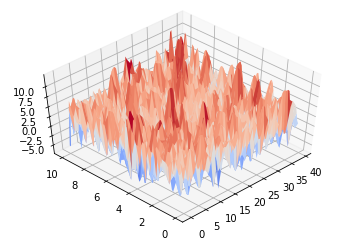

In [22]:
# Una vista en 3D del sistema

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

X, Y = np.meshgrid(np.arange(N), time_grid)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=50., azim=225)
ax.plot_surface(X.T, Y.T, xt, cmap=cm.coolwarm)

### Matriz de covarianzas del _background_

Interpolación óptima y 3DVar necesitan una matriz de covarianzas del background, $B$. Para obtener una $B$ razonable haremos una corrida larga del sistema y calcularemos la covarianza.

In [24]:
# Para obtener una B razonable haremos una corrida larga
# del sistema y calcularemos la covarianza

Nlong = 1000
xlong = np.zeros((N, Nlong))
xlong[:, 0] = x0 + scipy.stats.multivariate_normal(np.zeros(N), np.eye(N)).rvs()
for t in np.arange(1, Nlong):
    xlong[:, t] = M(t, xlong[:, t-1])

(40, 40)


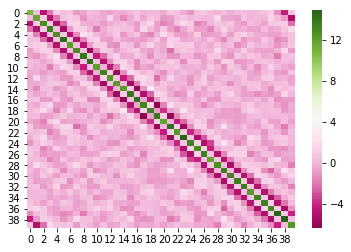

<Container object of 40 artists>

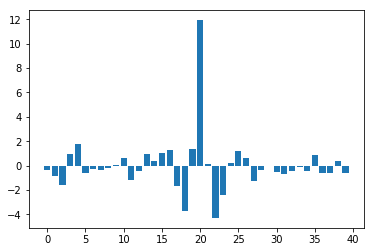

In [25]:
B = np.cov(xlong)
print(B.shape)
# print(B)

# Matriz de covarianzas
ax = sns.heatmap(B, cmap="PiYG")
plt.show()

# Covarianzas respecto a una dimensión del sistema (la dimensión "del medio")
plt.bar(np.arange(N), B[N//2,:])

### Interpolación Óptima
El algoritmo de interpolación óptima puede ser escrito como:

Para $t = 1,...,T$
* Computar el forecast
    * Si $t=1$ evolucionar $x_1^f = M(x_{0})$
    * Si $t>1$ evolucionar $x_t^f = M(x_{t-1}^a)$
* Computar la matriz de ganancia: $ K = BH^T(HBH^T + R)^{-1} $

* Computar el análisis: $ x_t^a = x_t^f + K(y_t - H(x_t)) $

In [ ]:
# Ahora implementaremos Interpolación Óptima y asimilaremos las observaciones sintéticas

xf =  np.zeros((N, ncy))
xa =  np.zeros((N, ncy))
xf[:, 0] = scipy.stats.multivariate_normal(x0, B).rvs()
xa[:, 0] = scipy.stats.multivariate_normal(x0, B).rvs()
    

for t in np.arange(1, ncy):
    # Forecast
    xf[:, t] = M(t, xa[:, t-1])
    
    # Analysis
    # Completar el código y, si no sale, correr la próxima celda 
    # para ver una posible implementación.
    # ...
    # xa[:, t] = ...

In [26]:
show_answer('OI')

In [ ]:
# Plots de la primera dimensión
plt.plot(time_grid, xt[0, :])
plt.plot(time_grid, xf[0, :])
plt.plot(time_grid, xa[0, :])
plt.plot(time_grid, y[0, :], 'r.')

In [ ]:
RMSE_a = np.sqrt(np.mean((xa-xt)**2))
RMSE_f = np.sqrt(np.mean((xf-xt)**2))
print('RMSE forecast: {}\n'.format(RMSE_f) +
      'RMSE analysis: {}'.format(RMSE_a))

### 3D-Var

Para computar el análisis usando 3DVar necesitamos computar la función de costo y su gradiente

\begin{align*}
J(x) &= (x-x_f)^T B^{-1} (x-x_f) + (y-Hx)^T R^{-1} (y-Hx) \\
\nabla J(x) &=  2 B^{-1} (x-x_f) + 2 H^T R^{-1} (y-Hx)
\end{align*}

para después minimizar J


In [ ]:
def cost(xf, y, H, Rinv, Binv):
    def J(x):
        #cost = ...
        return cost
    return J

def computegrad(xf, y, H, Rinv, Binv):
    def grad(x):
        #grad = ...
        return grad
    return grad

In [27]:
show_answer('3DVar J')

In [28]:
show_answer('3DVar gradJ')

In [ ]:
# En esta celda se hace la asimilación usando funciones correspondientes
# para el costo y su gradiente

xf =  np.zeros((N, ncy))
xa =  np.zeros((N, ncy))
xf[:, 0] = scipy.stats.multivariate_normal(x0, np.eye(N)).rvs()
xa[:, 0] = scipy.stats.multivariate_normal(x0, np.eye(N)).rvs()

Binv = np.linalg.inv(B)
Rinv = np.linalg.inv(R)
for t in np.arange(1, ncy):
    # Forecast
    xf[:, t] = M(t, xa[:, t-1])
    
    # Analysis
    J = cost(xf[:, t], y[:, t], H, Rinv, Binv)
    gradJ = computegrad(xf[:, t], y[:, t], H, Rinv, Binv)
    xa[:, t] = scipy.optimize.minimize(J, x0=xf[:, t], jac=gradJ).x

In [ ]:
# Plots de la primera dimensión
plt.plot(time_grid, xt[0, :])
plt.plot(time_grid, xf[0, :])
plt.plot(time_grid, xa[0, :])
plt.plot(time_grid, y[0, :], 'r.')

In [ ]:
RMSE_a = np.sqrt(np.mean((xa-xt)**2))
RMSE_f = np.sqrt(np.mean((xf-xt)**2))
print('RMSE forecast: {}\n'.format(RMSE_f) +
      'RMSE analysis: {}'.format(RMSE_a))

### EnKF

Para $t=0$
* Formar el ensamble inicial sampleando $ x_0^{(i)} \sim p(x_0)$    para   $i=1,...N_p$

Para $t = 1,...,T$ 
* Samplear el ruido de modelo para cada partícula $ \epsilon_t^{(i)} \sim N(0, Q) $
* Computar el forecast
    * Si $t=1$ evolucionar $x_{f,1}^{(i)} = M(x_0^{(i)}) + \epsilon_1^{(i)}$ para   $i=1,...N_p$
    * Si $t>1$ evolucionar $x_{f,t}^{(i)} = M(x_{t-1}^a) + \epsilon_t^{(i)}$ para   $i=1,...N_p$
* Computar la matriz de ganancia: $ K = SH^T(HSH^T + R)^{-1} $ donde $S$ es la covarianza muestral del ensamble $\{x_{f,t}^{(i)}\}$
* Samplear perturbaciones $ v_t^{(i)} \sim N(0, R)$ para   $i=1,...N_p$
* Computar el análisis: $ x_{a,t}^{(i)} = x_{f,t}^{(i)} + K(y_t + v_t^{(i)} - H(x_{f,t}^{(i)})) $ para   $i=1,...N_p$

In [ ]:
# Completar el código
def EnKF_analysis(xf, y, H, R, infl = 1.0):
    # ...
    return xa     

In [12]:
show_answer('EnKF')

In [ ]:
# En esta celda se hace la asimilación usando la función EnKF_analysis
# Ojo que esta celda puede demorar en ejecutarse si N, Np, ncy son grandes

Np = 100

xf =  np.zeros((N, Np, ncy))
xa =  np.zeros((N, Np, ncy))
xf[:, :, 0] = scipy.stats.multivariate_normal(x0, np.eye(N)).rvs(Np).T
xa[:, :, 0] = scipy.stats.multivariate_normal(x0, np.eye(N)).rvs(Np).T

for t in np.arange(1, ncy):
    # Forecast
    for j in np.arange(Np):
        xf[:, j, t] = M(t, xa[:, j, t-1])
    
    # Analysis
    xa[:, :, t] = EnKF_analysis(xf[:, :, t], y[:, t], H, R, infl = 1.0)
    

In [ ]:
# plots de la primera dimensión 
for j in np.arange(Np):
    plt.plot(time_grid, xa[0, j, :], '0.3')
plt.plot(time_grid, xt[0, :])
plt.plot(time_grid, y[0, :], 'r.')

In [ ]:
# plots de la primera dimensión (media del ensamble)

plt.plot(time_grid, xt[0, :])
plt.plot(time_grid, np.mean(xa[0, :, :], axis=0))
plt.plot(time_grid, y[0, :], 'r.')

In [ ]:
RMSE_a = np.sqrt(np.mean((np.mean(xa, axis=1)-xt)**2)) 
RMSE_f = np.sqrt(np.mean((np.mean(xf, axis=1)-xt)**2)) 
print('RMSE forecast: {}\n'.format(RMSE_f) +
      'RMSE analysis: {}'.format(RMSE_a))

In [ ]:
# En esta podremos visualizar los ensambles de análisis y de forecast 
# junto con la observación y los contornos de p(y|Hx)

t = 33
x1 = 0
x2 = -2


lik = scipy.stats.multivariate_normal(xt[[x1, x2], t], R[[x1, x2], [x1, x2]])


xmax = xt[x1, t] + 2*R[x1, x1]
xmin = xt[x1, t] - 2*R[x1, x1]
ymax = xt[x2, t] + 2*R[x2, x2]
ymin = xt[x2, t] - 2*R[x2, x2]
gridsize = 60
X = np.linspace(xmin, xmax, gridsize)
Y = np.linspace(ymin, ymax, gridsize)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y

Z = lik.pdf(pos)


plt.plot(xf[x1, :, t], xf[x2, :, t],'g.', label='forecast')
plt.plot(xa[x1, :, t], xa[x2, :, t],'b.', label='analysis')
plt.plot(y[x1, t], y[x2, t], 'ro', label='observation')
plt.plot(xt[x1, t], xt[x2, t], 'mo', label='truth')
plt.contour(X, Y, Z)
plt.legend()

